### Importing Dataset

In [1]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("imdb")
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

In [2]:
# Explore data
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"Label distribution: {train_df['label'].value_counts()}")

Training set shape: (25000, 2)
Test set shape: (25000, 2)
Label distribution: label
0    12500
1    12500
Name: count, dtype: int64


In [3]:
# Sample Data

print(train_df.head())

                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


In [4]:
# Check for missing values

print(f"Missing Values: {train_df.isnull().sum()}")

Missing Values: text     0
label    0
dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

## Create validation set from training data
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'])

In [6]:
val_df

,text,label
8554,"""Kids Like These"" could have been a decent fil...",0
11157,I saw this movie last month at a free sneak pr...,0
2443,The fact that this movie made it all the way t...,0
15172,I rented this film from Netflix for two reason...,1
12352,A recent post here by a woman claiming a milit...,0
...,...,...
19375,The movie was much better than the other revie...,1
2733,Hollywood Hotel was the last movie musical tha...,0
10048,I've now written reviews for several of the Mo...,0
14558,"Viewing ""Impulse"" is a very satisfying experie...",1


In [7]:
train_df

,text,label
6740,"""Algie, the Miner"" is one bad and unfunny sile...",0
8635,This is a complete Hoax...<br /><br />The movi...,0
17340,"Nifty little episode played mainly for laughs,...",1
2303,Perhaps the worst thing about Carlos Mencia's ...,0
6014,"First of all, I firmly believe that Norwegian ...",0
...,...,...
23542,The sopranos was probably the last best show t...,1
15402,"As part of our late 1950s vocabulary, we well ...",1
10468,Quite what the producers of this appalling ada...,0
5163,"""Trigger Man"" is definitely the most boring an...",0


In [8]:
test_df

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0
...,...,...
24995,Just got around to seeing Monster Man yesterda...,1
24996,I got this as part of a competition prize. I w...,1
24997,I got Monster Man in a box set of three films ...,1
24998,"Five minutes in, i started to feel how naff th...",1


### Model Selection

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Choose model type based on your requirements
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/Users/bhushannimje/env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Data Preprocessing for BERT

In [10]:
def preprocess_data(texts, labels, tokenizer, max_length=128):
    """Tokenize and prepare data for BERT."""
    
    encoded_batch = tokenizer(
        texts,
        add_special_tokens=True,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    encoded_batch['labels'] = labels
    return encoded_batch

# Preprocess training data
train_encodings = preprocess_data(
    train_df['text'].tolist(), 
    train_df['label'].tolist(), 
    tokenizer
)

# Preprocess validation data
val_encodings = preprocess_data(
    val_df['text'].tolist(), 
    val_df['label'].tolist(), 
    tokenizer
)

# Create PyTorch datasets
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
        
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        return item
    
    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = SentimentDataset(train_encodings)
val_dataset = SentimentDataset(val_encodings)

### Model Implementation

In [11]:
import torch
from torch import nn
from transformers import BertModel

class BertForSentimentClassification(nn.Module):
    def __init__(self, bert_model_name, num_labels=2):
        super(BertForSentimentClassification, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits

# Alternatively, use a pre-built model
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=2  # binary classification
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training Loop

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import os

# Define batch size
batch_size = 16

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define number of epochs
num_epochs = 4  # Moved here before using in total_steps

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Calculate total training steps for the scheduler
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
best_accuracy = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training phase
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )

        # Compute loss
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(outputs.logits, batch['labels'])

        # Backpropagation
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )

            loss = loss_fn(outputs.logits, batch['labels'])
            val_loss += loss.item()

            # Compute accuracy
            preds = torch.argmax(outputs.logits, dim=1)
            val_correct += (preds == batch['labels']).sum().item()

    val_accuracy = val_correct / len(val_dataset)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Ensure 'models' directory exists
    os.makedirs("models", exist_ok=True)

    # Save best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'models/best_model.pt')
        print(f"New best model saved with accuracy: {best_accuracy:.4f}")



Epoch 1/4


/Users/bhushannimje/env/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1:   0%|          | 0/1407 [00:00<?, ?it/s]

Average Training Loss: 0.3465


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.2715
Validation Accuracy: 0.8876
New best model saved with accuracy: 0.8876

Epoch 2/4


Training Epoch 2:   0%|          | 0/1407 [00:00<?, ?it/s]

Average Training Loss: 0.2060


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.2983
Validation Accuracy: 0.8892
New best model saved with accuracy: 0.8892

Epoch 3/4


Training Epoch 3:   0%|          | 0/1407 [00:00<?, ?it/s]

Average Training Loss: 0.1173


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.4828
Validation Accuracy: 0.8852

Epoch 4/4


Training Epoch 4:   0%|          | 0/1407 [00:00<?, ?it/s]

Average Training Loss: 0.0588


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.5497
Validation Accuracy: 0.8924
New best model saved with accuracy: 0.8924


### Evaluation

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                token_type_ids=batch.get('token_type_ids', None)
            )
            
            # Extract logits and apply argmax
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(batch['labels'].cpu().numpy())
    
    # Classification report
    print(classification_report(true_labels, predictions, target_names=['Negative', 'Positive']))
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return predictions, true_labels

/var/folders/2g/lmk1bhjs5_z_mmz5n04j_f8w0000gn/T/ipykernel_4783/2818236404.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best

Evaluating:   0%|          | 0/1563 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Negative       0.90      0.87      0.89     12500
    Positive       0.88      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



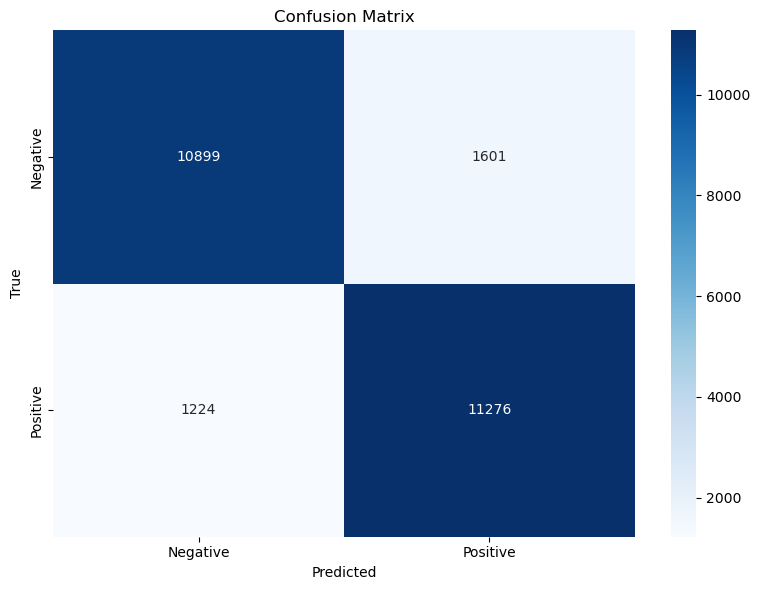

In [15]:
# Preprocess test data
test_encodings = preprocess_data(
    test_df['text'].tolist(), 
    test_df['label'].tolist(), 
    tokenizer
)
test_dataset = SentimentDataset(test_encodings)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load best model
model.load_state_dict(torch.load('models/best_model.pt'))
predictions, true_labels = evaluate_model(model, test_loader, device)

In [17]:
# After training your model
def save_model(model, tokenizer, output_dir='sentiment_model'):
    # Create output directory if it doesn't exist
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save model
    model.save_pretrained(output_dir)
    
    # Save tokenizer
    tokenizer.save_pretrained(output_dir)
    
    print(f"Model and tokenizer saved to {output_dir}")

# Usage
save_model(model, tokenizer)

Model and tokenizer saved to sentiment_model
